In [401]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from collections import Counter
from sklearn import impute
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import make_pipeline, Pipeline 
from gower import gower_matrix
from prince import MCA, FAMD, MFA, PCA
from hyperopt import fmin, tpe, hp, Trials
from utils import draw_clusters, scores_calc, multiple_graphs
%matplotlib inline

In [402]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="using precomputed metric; inverse_transform will be unavailable")

In [403]:
data = pd.read_csv('/Users/e.kireev/Desktop/users_segmentation/Result_59.csv')
data.head(100)

,id,cls,title,geo_target,for_kids,duration,overall_duration,is_4k,devices,total_episodes,total_seasons,genres,rating_imdb,rating_age,rating_kp,rating_start,rating_total,year,popularity,popularity_kids
0,394ec71b-ee9c-49a7-ba63-dcf2bf97f50b,Movie,Лена и львенок,"['EE', 'LT', 'LV', 'AZ', 'AM', 'BY', 'KG', 'KZ...",True,5402500,0,False,"['Web', 'Mobile', 'TV']",NaN,NaN,"['family', 'comedy', 'adventure']",5.4,6,7.8,NaN,8.4,2020.0,70.0,70.0
1,4fb22f07-16d5-4659-ae03-5bae62ccc949,Series,Под прикрытием,['RU'],False,0,49706880,False,"['Web', 'Mobile', 'TV']",22.0,1.0,"['melodrama', 'comedy', 'action']",6.5,16,7.5,NaN,7.9,2022.0,81.0,NaN
2,3ddcdfb9-23fd-423b-a859-914a6e71c5d0,Movie,Подростки: Первая любовь,"['AZ', 'AM', 'BY', 'KG', 'KZ', 'MD', 'RU', 'TJ...",False,6097042,0,True,"['Web', 'Mobile', 'TV']",NaN,NaN,"['melodrama', 'music', 'youth']",5.8,18,7.2,NaN,8.2,2024.0,725.0,NaN
3,550ce943-319d-4dd4-a984-446a0317a721,Series,КрисТина,"['AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO...",False,0,12328120,True,"['Web', 'Mobile', 'TV']",18.0,1.0,"['thriller', 'drama']",7.4,18,6.2,NaN,6.8,2021.0,745.0,NaN
4,5276792f-926e-440f-acc8-63739b38c64c,Movie,"Музыка, исцеляющая души",['RU'],False,714960,0,False,"['Web', 'Mobile', 'TV']",NaN,NaN,['documental'],NaN,12,NaN,NaN,NaN,2016.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,073d0610-9914-4662-b12e-04f338359bc9,Movie,Мини-вселенная,['RU'],False,2999840,0,False,"['Web', 'Mobile', 'TV']",NaN,NaN,['documental'],6.6,18,NaN,NaN,NaN,2017.0,25.0,NaN
96,b7758553-9042-463c-a3a4-eaef12916e5c,Movie,Счастье в конверте,"['AZ', 'AM', 'BY', 'KG', 'KZ', 'MD', 'RU', 'TJ...",False,5885480,0,False,['Web'],NaN,NaN,"['melodrama', 'family']",6.4,18,8.4,NaN,9.0,2020.0,1.0,NaN
97,1683de62-935b-4ac7-9c95-02083ebfd7d0,Movie,Принципиально документально,"['AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO...",False,1341200,0,False,"['Web', 'Mobile', 'TV']",NaN,NaN,"['comedy', 'short']",NaN,18,7.1,NaN,6.9,2021.0,149.0,NaN
98,fa8c70f1-dd94-4bd9-8e80-60004007da4a,Movie,Доктор Лиза,"['AM', 'AZ', 'BY', 'GE', 'KZ', 'KG', 'MD', 'RU...",False,6910840,0,False,['Web'],NaN,NaN,"['drama', 'bio']",7.2,18,8.3,NaN,8.4,2020.0,1.0,NaN


In [404]:
data.isnull().sum()

id                     0
cls                    0
title                  0
geo_target             0
for_kids               0
duration               0
overall_duration       0
is_4k                  0
devices                0
total_episodes      1017
total_seasons       1017
genres                 0
rating_imdb          289
rating_age             0
rating_kp            199
rating_start        1586
rating_total         275
year                   1
popularity             9
popularity_kids     1331
dtype: int64

In [405]:
df = data.drop(['id', 'title'], axis=1)
df.head()

,cls,geo_target,for_kids,duration,overall_duration,is_4k,devices,total_episodes,total_seasons,genres,rating_imdb,rating_age,rating_kp,rating_start,rating_total,year,popularity,popularity_kids
0,Movie,"['EE', 'LT', 'LV', 'AZ', 'AM', 'BY', 'KG', 'KZ...",True,5402500,0,False,"['Web', 'Mobile', 'TV']",NaN,NaN,"['family', 'comedy', 'adventure']",5.4,6,7.8,NaN,8.4,2020.0,70.0,70.0
1,Series,['RU'],False,0,49706880,False,"['Web', 'Mobile', 'TV']",22.0,1.0,"['melodrama', 'comedy', 'action']",6.5,16,7.5,NaN,7.9,2022.0,81.0,NaN
2,Movie,"['AZ', 'AM', 'BY', 'KG', 'KZ', 'MD', 'RU', 'TJ...",False,6097042,0,True,"['Web', 'Mobile', 'TV']",NaN,NaN,"['melodrama', 'music', 'youth']",5.8,18,7.2,NaN,8.2,2024.0,725.0,NaN
3,Series,"['AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO...",False,0,12328120,True,"['Web', 'Mobile', 'TV']",18.0,1.0,"['thriller', 'drama']",7.4,18,6.2,NaN,6.8,2021.0,745.0,NaN
4,Movie,['RU'],False,714960,0,False,"['Web', 'Mobile', 'TV']",NaN,NaN,['documental'],NaN,12,NaN,NaN,NaN,2016.0,6.0,NaN


In [406]:
imp = impute.SimpleImputer(strategy = "constant", fill_value=0)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.drop(num_cols, axis=1).columns
df[num_cols] = imp.fit_transform(df[num_cols])
df.head()

,cls,geo_target,for_kids,duration,overall_duration,is_4k,devices,total_episodes,total_seasons,genres,rating_imdb,rating_age,rating_kp,rating_start,rating_total,year,popularity,popularity_kids
0,Movie,"['EE', 'LT', 'LV', 'AZ', 'AM', 'BY', 'KG', 'KZ...",True,5402500.0,0.0,False,"['Web', 'Mobile', 'TV']",0.0,0.0,"['family', 'comedy', 'adventure']",5.4,6.0,7.8,0.0,8.4,2020.0,70.0,70.0
1,Series,['RU'],False,0.0,49706880.0,False,"['Web', 'Mobile', 'TV']",22.0,1.0,"['melodrama', 'comedy', 'action']",6.5,16.0,7.5,0.0,7.9,2022.0,81.0,0.0
2,Movie,"['AZ', 'AM', 'BY', 'KG', 'KZ', 'MD', 'RU', 'TJ...",False,6097042.0,0.0,True,"['Web', 'Mobile', 'TV']",0.0,0.0,"['melodrama', 'music', 'youth']",5.8,18.0,7.2,0.0,8.2,2024.0,725.0,0.0
3,Series,"['AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO...",False,0.0,12328120.0,True,"['Web', 'Mobile', 'TV']",18.0,1.0,"['thriller', 'drama']",7.4,18.0,6.2,0.0,6.8,2021.0,745.0,0.0
4,Movie,['RU'],False,714960.0,0.0,False,"['Web', 'Mobile', 'TV']",0.0,0.0,['documental'],0.0,12.0,0.0,0.0,0.0,2016.0,6.0,0.0


In [407]:
max(df.isnull().sum())

0

In [408]:
# sns.heatmap(df[num_cols].corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
# plt.show()

In [409]:
# df = df.drop(['rating_kp', 'rating_imdb', 'duration'], axis=1)
# num_cols = num_cols.drop(['rating_kp', 'rating_imdb', 'duration'])

In [410]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# import pandas as pd
# 
# X_scaled = StandardScaler().fit_transform(df[num_cols])
# pca = PCA()
# pca.fit(X_scaled)
# loadings = pd.DataFrame(pca.components_.T, index=df[num_cols].columns)
# explained_var = pca.explained_variance_ratio_
# np.abs(loadings).multiply(explained_var, axis=1).sum(axis=1)
# feature_importance = (np.abs(loadings).multiply(explained_var, axis=1)).sum(axis=1)
# feature_importance = feature_importance.sort_values(ascending=False)
# feature_importance

from prince import PCA
pca = PCA(n_components=len(df[num_cols].columns), rescale_with_mean=True, rescale_with_std=True, random_state=42, engine='sklearn')
pca.fit(df[num_cols])
loadings = pca.column_correlations
explained_var = pca.eigenvalues_
feature_importance = (np.abs(loadings).multiply(explained_var, axis=1)).sum(axis=1)
feature_importance = feature_importance.sort_values(ascending=False)

In [411]:
X = df[list(dict(feature_importance).keys())[:3]]
num_features = X.columns
X.head()

,duration,overall_duration,total_seasons
0,5402500.0,0.0,0.0
1,0.0,49706880.0,1.0
2,6097042.0,0.0,0.0
3,0.0,12328120.0,1.0
4,714960.0,0.0,0.0


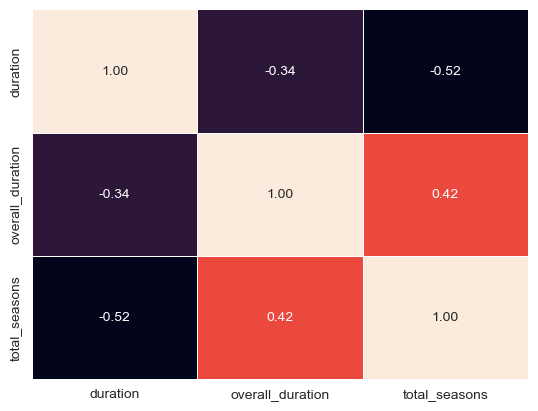

In [412]:
sns.heatmap(X.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

In [413]:
from hyperopt import STATUS_OK
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, BisectingKMeans
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

models = {
    'bisecting_kmeans': BisectingKMeans,
    'kmeans': KMeans
}
scalers = {
    'robust_scaler': RobustScaler,
    'min_max_scaler': MinMaxScaler,
    'standard_scaler': StandardScaler
}
def objective(params):
    n_clrs = int(params['n_clusters'])
    selected_model = models[params['model']]
    selected_scaler = scalers[params['scaler']]
    
    ct = ColumnTransformer([
        ('scaler', selected_scaler(), num_features)
    ])
    pl = Pipeline(steps=[
        ('ct', ct),
        ('model', selected_model(n_clusters=n_clrs, random_state=42))
    ])
    pl.fit(X)    
    clrs = pl.predict(X)
    # ss = silhouette_score(X, clrs)
    ss, chs, dbi = scores_calc(X, clrs, 'precomputed')
    penalty = 0.1 * n_clrs
    cost = pl.named_steps['model'].inertia_
    return {
            'loss': -ss + cost + dbi + penalty,
            # 'loss': -ss + cost + dbi,
            'status': STATUS_OK,
            'n_clusters': n_clrs,
            'silhouette': ss,
            'calinski_harabasz': chs,
            'davies_bouldin': dbi,
            'cost': cost,
            'clusters': clrs,
            'selected_model': selected_model,
            'selected_scaler': selected_scaler, 
            'best_pipeline': pl
        }
space = {
    'n_clusters': hp.choice('n_clusters', range(2, 50)),
    'model': hp.choice('model', list(models.keys())),
    'scaler': hp.choice('encoder', list(scalers.keys()))
}
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print(trials.best_trial['result'])

100%|██████████| 50/50 [00:08<00:00,  6.19trial/s, best loss: 3.1499213696482604]
{'loss': 3.1499213696482604, 'status': 'ok', 'n_clusters': 20, 'silhouette': 0.5884449, 'calinski_harabasz': 13371.132018393888, 'davies_bouldin': 0.9472775768531985, 'cost': 0.7910886813868283, 'clusters': array([15,  0, 11, ...,  0, 15,  0], dtype=int32), 'selected_model': <class 'sklearn.cluster._kmeans.KMeans'>, 'selected_scaler': <class 'sklearn.preprocessing._data.MinMaxScaler'>, 'best_pipeline': Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  Index(['duration', 'overall_duration', 'total_seasons'], dtype='object'))])),
                ('model', KMeans(n_clusters=20, random_state=42))])}


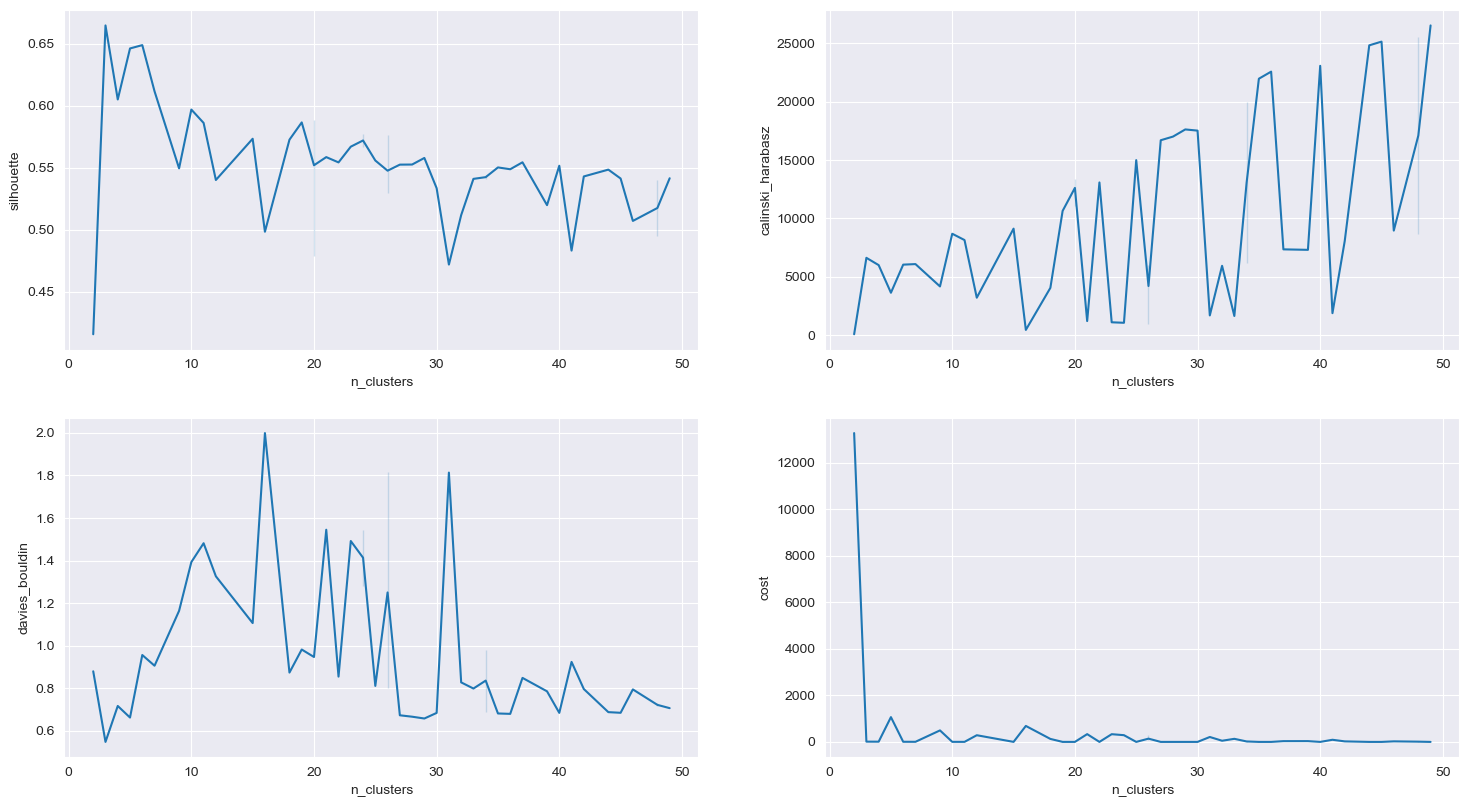

In [414]:
clusters = trials.best_trial['result']['clusters']
multiple_graphs(2, 'n_clusters', pd.DataFrame(trials.results).sort_values('loss').drop(['status', 'loss', 'selected_model', 'selected_scaler', 'best_pipeline', 'clusters'], axis=1))

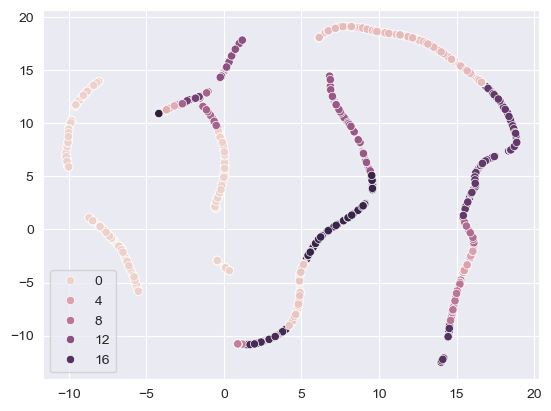

In [415]:
gm = gower_matrix(X)
emb = umap.UMAP(metric='euclidean').fit_transform(gm)
sns.scatterplot(x=emb[:, 0], y=emb[:, 1], hue=clusters)
plt.show()

Оцениваем важность категориальных признаков

In [173]:
cat_data = df[cat_cols]
mca = MCA(n_iter=10, random_state=42, engine='sklearn')
mca = mca.fit(cat_data)
modality_contributions = mca.column_contributions_
explained_inertia = mca.eigenvalues_

dummy_to_feat = [col.split('_')[0] for col in modality_contributions.index]

feat_importance = {}
for feat in set(dummy_to_feat):
    idx = [i for i,f in enumerate(dummy_to_feat) if f == feat]
    m = modality_contributions.iloc[idx,:].values
    imp = np.sum(np.abs(m) * explained_inertia, axis=1).sum()
    feat_importance[feat] = imp
feat_importance = pd.Series(feat_importance).sort_values(ascending=False)
print(feat_importance)

genres     0.265597
geo        0.230285
devices    0.119772
for        0.119519
cls        0.066776
is         0.023798
dtype: float64


In [174]:
X = df[cat_cols].drop(['devices'], axis=1)
cat_features = X.columns.tolist()

In [175]:
# from hyperopt import STATUS_OK
# from sklearn.pipeline import Pipeline
# from sklearn.cluster import KMeans, BisectingKMeans
# import category_encoders as ce
# from sklearn.compose import ColumnTransformer
# 
# models = {
#     'bisecting_kmeans': BisectingKMeans,
#     'kmeans': KMeans
# }
# encoders = {
#     'one_hot_encoder': ce.OneHotEncoder,
#     'binary_encoder': ce.BinaryEncoder,
#     'count_encoder': ce.CountEncoder,
#     'ordinal_encoder': ce.OrdinalEncoder,
#     'hashing_encoder': ce.HashingEncoder,
#     'RankHotEncoder': ce.RankHotEncoder
# }
# def objective_compare(params):
#     n_clrs = int(params['n_clusters'])
#     selected_model = models[params['model']]
#     selected_encoder = encoders[params['encoder']]
#     
#     ct = ColumnTransformer([
#         ('cat', selected_encoder(), cat_features)
#     ], remainder='drop')
#     pl = Pipeline(steps=[
#         ('ct', ct),
#         ('model', selected_model(n_clusters=n_clrs, random_state=42))
#     ])
#     pl.fit(X)    
#     clrs = pl.predict(X)
#     ss, chs, dbi = scores_calc(X, clrs, 'precomputed')
#     penalty = 0.1 * n_clrs
#     return {
#             'loss': -ss + dbi - chs + penalty,
#             'status': STATUS_OK,
#             'n_clusters': n_clrs,
#             'silhouette': ss,
#             'calinski_harabasz': chs,
#             'davies_bouldin': dbi,
#             'clusters': clrs,
#             'selected_model': selected_model,
#             'selected_encoder': selected_encoder, 
#             'best_pipeline': pl
#         }
# space = {
#     'n_clusters': hp.choice('n_clusters', range(2, 50)),
#     'model': hp.choice('model', list(models.keys())),
#     'encoder': hp.choice('encoder', list(encoders.keys()))
# }
# trials = Trials()
# best = fmin(fn=objective_compare, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
# print(trials.best_trial['result'])

Оцениваем важность числовых признаков

In [176]:
from prince import PCA
pca = PCA(n_components=len(df[num_cols].columns), rescale_with_mean=True, rescale_with_std=True, random_state=42, engine='sklearn')
pca.fit(df[num_cols])
loadings = pca.column_correlations
explained_var = pca.eigenvalues_
feature_importance = (np.abs(loadings).multiply(explained_var, axis=1)).sum(axis=1)
feature_importance = feature_importance.sort_values(ascending=False)
feature_importance

variable
duration            3.372992
overall_duration    3.333577
total_seasons       3.137302
rating_imdb         3.092071
rating_total        3.025690
total_episodes      2.953241
popularity_kids     2.803745
rating_kp           2.780348
popularity          2.621382
rating_age          2.477790
rating_start        1.865147
year                1.858949
dtype: float64

In [177]:
df[num_cols]

,duration,overall_duration,total_episodes,total_seasons,rating_imdb,rating_age,rating_kp,rating_start,rating_total,year,popularity,popularity_kids
0,5402500.0,0.0,0.0,0.0,5.4,6.0,7.8,0.0,8.4,2020.0,70.0,70.0
1,0.0,49706880.0,22.0,1.0,6.5,16.0,7.5,0.0,7.9,2022.0,81.0,0.0
2,6097042.0,0.0,0.0,0.0,5.8,18.0,7.2,0.0,8.2,2024.0,725.0,0.0
3,0.0,12328120.0,18.0,1.0,7.4,18.0,6.2,0.0,6.8,2021.0,745.0,0.0
4,714960.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,2016.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1603,1549080.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,2024.0,11.0,0.0
1604,3000080.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,2020.0,3.0,0.0
1605,0.0,22474240.0,9.0,1.0,0.0,18.0,8.6,0.0,8.5,2021.0,7.0,0.0
1606,5257880.0,0.0,0.0,0.0,5.6,18.0,5.9,0.0,6.1,2013.0,1.0,0.0
